# 卷積的概念

## 簡單卷積

In [1]:
import numpy as np

# 設定隨機種子，確保每次執行產生的亂數都一樣（方便除錯）
np.random.seed(5)

# 產生一個包含 10 個元素的陣列，數值介於 1 到 30 之間，資料型態為長整數 (long)
x = np.random.randint(low=1, high=30, size=10, dtype='l')
print(x)

# 定義權重陣列（或是過濾器 Filter/Kernel）
w = np.array([1.2, 0.3, 0.5])

# 取得原始資料 x 的長度與權重 w 的長度
n = x.size
K = w.size

# 初始化一個全為 0 的陣列 z，用來存放計算結果
# 長度設定為 n-K+1 是為了確保滑動視窗不會超出邊界 (Valid Padding)
z = np.zeros(n-K+1)

# 開始跑迴圈進行滑動視窗計算
for i in range(n-K+1):
    # 取出 x 的子部分與權重 w 進行元素對應相乘後加總 (點積運算)
    z[i] = np.sum(x[i:i+K] * w)

# 輸出權重與最終計算出來的結果
print(w)
print(z)

[ 4 15 16  7 23 17 10  9  5  8]
[1.2 0.3 0.5]
[17.3 26.3 32.8 23.8 37.7 27.9 17.2 16.3]


## Same 與 Full 卷積

In [2]:
def conv1d(x, w, pad):
    # 取得輸入資料 x 的長度與權重 w (Kernel) 的長度
    n = x.size
    K = w.size

    # 計算總共要補零的數量（左右兩邊各補 pad 個 0）
    P = 2 * pad

    # 計算輸出陣列的長度 (公式：輸入長度 + 總填充 - 核心長度 + 1)
    n_o = n + P - K + 1

    # 初始化輸出陣列 y
    y = np.zeros(n_o)

    # 判斷是否需要進行 Padding
    if P > 0:
        # 建立一個補零後的新陣列，長度為原本長度加上 P
        x_pad = np.zeros(n + P)
        # 將原本的資料 x 塞進中間，避開頭尾需要補 0 的位置
        x_pad[pad:-pad] = x
    else:
        # 如果不需補零，直接使用原始資料
        x_pad = x

    # 開始執行滑動視窗運算
    for i in range(n_o):
        # 在補零後的陣列上，取出對應區段與權重相乘並加總
        y[i] = np.sum(x_pad[i:i + K] * w)

    return y

In [3]:
# 執行 Same 卷積：透過補 1 層零 (pad=1)，讓輸出的長度儘可能跟輸入一樣
y1 = conv1d(x, w, 1)
# 印出原始資料長度、權重長度以及計算後的長度
print(x.size, w.size, y1.size)
print("same: ", y1)

# 執行 Full 卷積：補上足夠的零 (pad=2)，讓權重只要「沾到邊」就開始計算
# 這會讓輸出的長度達到最大值 (n + K - 1)
y2 = conv1d(x, w, 2)
print(x.size, w.size, y2.size)
print("full: ", y2)

10 3 10
same:  [ 8.7 17.3 26.3 32.8 23.8 37.7 27.9 17.2 16.3  8.4]
10 3 12
full:  [ 2.   8.7 17.3 26.3 32.8 23.8 37.7 27.9 17.2 16.3  8.4  9.6]


In [4]:
def conv1d(x, w, pad=0, s=1): 
    # 取得輸入長度 n 與核心 (Kernel) 長度 K
    n = x.size
    K = w.size   
    
    # 計算輸出長度公式 (考慮 Stride 步長)
    # 使用 // 是整數除法，確保索引是整數
    n_o = (n + 2 * pad - K) // s + 1
    
    # 初始化用來存放卷積結果的陣列 y
    y = np.zeros(n_o)             
    
    # 處理填充 (Padding)
    if not pad == 0:
        # 使用 np.pad 進行常數填充（預設補 0）
        # [(pad, pad)] 代表在陣列的前後各補 pad 個元素
        x_pad = np.pad(x, [(pad, pad)], mode='constant')
    else:
        # 若 pad 為 0 則直接使用原資料
        x_pad = x
    
    # 開始跑迴圈，逐一掃描計算結果
    for i in range(n_o): 
        # 計算視窗的起點：將索引 i 乘以步長 s
        # 這裡執行 Element-wise 相乘與加總
        y[i] = np.sum(x_pad[i*s : i*s + K] * w)            
        
    return y

In [ ]:
y0 = conv1d(x, w, 0) 
y1 = conv1d(x, w, 0, s=2)    
y2 = conv1d(x, w, 1, s=2)  
print(y0)
print(y1)
print(y2)

[17.3 26.3 32.8 23.8 37.7 27.9 17.2 16.3]
[17.3 32.8 37.7 17.2]
[ 8.7 26.3 23.8 27.9 16.3]


## 一維卷積

以下展示的在一維數列上所謂卷積的概念，可以藉由卷積來轉換資料，去除雜訊、獲取特定資料的特徵都常以這樣的方式來進行。

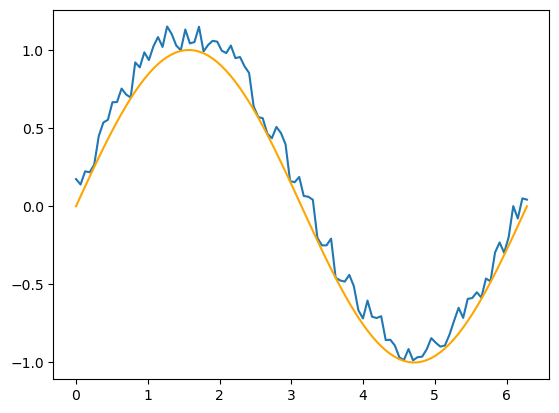

In [23]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# 在 0 到 2π 之間產生 100 個均勻分布的點
x = np.linspace(0, 2 * np.pi, 100)

# 產生正弦波，並加上隨機雜訊
# np.random.random(100) 會產生 0 到 1 之間的浮點數
# 乘以 0.2 是為了把雜訊的振幅縮小，讓它看起來像是「抖動」
y = np.sin(x) + np.random.random(100) * 0.2
y_unbias = np.sin(x)

# 呼叫 Matplotlib 畫出折線圖
plt.plot(x, y)
plt.plot(x, y_unbias, color='orange')

# 顯示圖表
plt.show()

以下使用在訊號處理與影像處理中極其重要的一維高斯函數（1D Gaussian Function）建立高斯權重 (Gaussian weights) 可以對雜訊訊號進行平滑化 (Smoothing)。

計算權重 $w$ 的數學表達式如下：$$w = e^{-\frac{x^2}{2\sigma^2}}$$

常態分配機率分布函數和它類似：$$f(x) = \frac{1}{\sigma\sqrt{2\pi}} e^{-\frac{x^2}{2\sigma^2}}$$

高斯分佈的特性：發現中間（$x=0$ 附近）的權重最高，越往兩邊越低。這代表在做卷積時，距離中心點越近的資料會給予較大的權重，而離得越遠的權重越小，這也就是降低雜訊的概念。

這個整數序列為 x_for_w: [-6 -5 -4 -3 -2 -1  0  1  2  3  4  5]
['0.00', '0.00', '0.01', '0.05', '0.12', '0.20', '0.23', '0.20', '0.12', '0.05', '0.01', '0.00']


<BarContainer object of 12 artists>

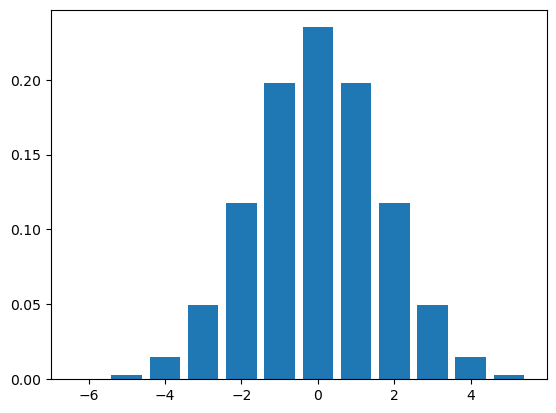

In [20]:
# 設定標準差 (Sigma)，這決定了高斯曲線（又稱常態分佈曲線或鐘形曲線）的寬度（也就是模糊的程度）
sigma = 1.6986436005760381

# 產生一個從 -6 到 5 的整數序列，作為權重的 x 軸座標
x_for_w = np.arange(-6, 6)
print("這個整數序列為 x_for_w:", x_for_w)

# 根據高斯函數公式計算對應的權重 y 值 (未歸一化)
# 公式：exp(-x^2 / (2 * sigma^2))
w = np.exp(-(x_for_w) ** 2 / (2 * sigma ** 2))

# 歸一化 (Normalization)：確保所有權重的總和等於 1
# 這樣卷積後的數值才不會被無故放大或縮小
w = w / sum(w)

# 以兩位小數的格式印出每個權重值，方便觀察數值分佈
print(["%0.2f" % x for x in w])

# 使用長條圖 (Bar Chart) 視覺化這個高斯分佈
plt.bar(x_for_w, w)

接下來則以前面產生的高斯函數權重 w，使用 np.correlate 執行互相關運算（在對稱權重下，結果等同於卷積）。

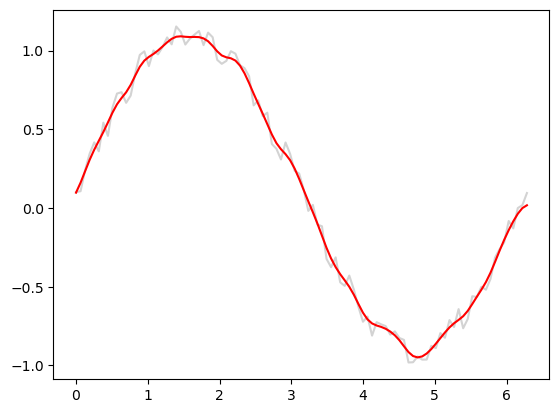

In [ ]:
# 原本註解掉的 w 是簡單的權重，這個可以用來測試如果沒有經過高斯函數處理的話，結果會是什麼樣子
# w = np.array([0.1, 0.2, 0.5, 0.2, 0.1])

# 以高斯函數權重 w 對原始資料 y 進行卷積運算
# mode="same" 代表輸出長度會與輸入 y 一致，內部會自動處理 Padding
# yhat 代表預測值或平滑後的結果（hat 在統計學中常用來表示估計值）
yhat = np.correlate(y, w, "same")

# 將平滑後的結果畫出來，並設定為紅色以便區隔，原來的曲線則以淺灰色顯示作為對比
plt.plot(x, y, color='lightgray')
plt.plot(x, yhat, color='red')